In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
def process_batting_data(file_path):
    # Load the data
    data = pd.read_excel(file_path)
    print("Original columns:", data.columns.tolist())
    
    # Work directly with the Excel data
    df = data.copy()
    
    # Define essential columns that should be present in both datasets
    essential_columns = ['Player', 'Mat', 'Inns', 'NO', 'Runs', 'HS', 'Ave', 'BF', 'SR', 
                        "100's", "50's", 0, '4s', '6s']
    
    # Verify all essential columns exist
    missing_cols = [col for col in essential_columns if col not in df.columns]
    if missing_cols:
        raise ValueError(f"Missing essential columns: {missing_cols}")
    
    # Print original HS values for verification
    print("\nBefore processing - Sample HS values:")
    print(df[['Player', 'HS']].head(10))
    
    # Clean and convert HS data more carefully
    def clean_hs(value):
        if pd.isna(value) or value == '-':
            return 0
        # Remove '*' if present and convert to string
        value = str(value).replace('*', '')
        # Convert to integer
        try:
            return int(value)
        except ValueError:
            print(f"Warning: Could not convert HS value '{value}' to integer")
            return 0
    
    # Apply the cleaning function to HS column
    df['HS'] = df['HS'].apply(clean_hs)
    
    # Print processed HS values for verification
    print("\nAfter processing - Sample HS values:")
    print(df[['Player', 'HS']].head(10))
    
    # Replace '-' with 0 in other numeric columns
    numeric_columns = ['Mat', 'Inns', 'NO', 'Runs', 'Ave', 'BF', 'SR', "100's", "50's", 0, '4s', '6s']
    for col in numeric_columns:
        df[col] = df[col].replace('-', 0).astype(float)
    
    # Feature Engineering
    df['Dismissals'] = df['Inns'] - df['NO']
    df['RunsPerInning'] = df['Runs'].div(df['Inns'].replace(0, 1))
    df['FiftyPlusPerInning'] = (df["50's"] + df["100's"]).div(df['Inns'].replace(0, 1))
    df['DucksPerInning'] = df[0].div(df['Inns'].replace(0, 1))
    df['BoundaryPercentage'] = df.apply(lambda x: ((x['4s'] * 4) + (x['6s'] * 6)) / x['Runs'] if x['Runs'] != 0 else 0, axis=1)
    df['BallsPerBoundary'] = df.apply(lambda x: x['BF'] / (x['4s'] + x['6s']) if (x['4s'] + x['6s']) != 0 else 0, axis=1)
    df['NonBoundarySR'] = df.apply(lambda x: 
        ((x['Runs']-(x['4s'] * 4) - (x['6s'] * 6))/(x['BF']-x['4s']-x['6s']))*100 
        if (x['BF']-x['4s']-x['6s']) != 0 else 0, axis=1)
    
    return df

In [3]:
def analyze_and_visualize(df):
    # Select Features for Analysis
    features = ['Ave', 'RunsPerInning', 'FiftyPlusPerInning', 'DucksPerInning', 'SR', 
                'NonBoundarySR', 'BoundaryPercentage', 'BallsPerBoundary']
    df_analysis = df[features]
    
    # Replace infinities and NaN with 0
    df_analysis = df_analysis.replace([np.inf, -np.inf], 0)
    df_analysis = df_analysis.fillna(0)
    
    # Correlation Analysis
    correlation_matrix = df_analysis.corr()
    
    # Visualize Correlation Matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
    plt.title('Correlation Matrix of Features')
    plt.show()
    
    return df_analysis

In [4]:
def calculate_ratings(df_analysis, df):
    # Normalize Features
    scaler = MinMaxScaler()
    features = df_analysis.columns
    df_normalized = pd.DataFrame(scaler.fit_transform(df_analysis), columns=features)
    df_normalized['Player'] = df['Player']
    
    # Calculate Scores
    df_normalized['Consistency'] = (0.4 * df_normalized['Ave']) + \
                                 (0.3 * df_normalized['FiftyPlusPerInning']) + \
                                 (0.1 * df_normalized['NonBoundarySR'])
    df_normalized['Form'] = (0.6 * df_normalized['Ave']) + (0.4 * df_normalized['SR'])
    df_normalized['Overall_Rating'] = (0.7 * df_normalized['Consistency']) + (0.3 * df_normalized['Form'])
    
    # Return Results
    return df_normalized[['Player', 'Consistency', 'Form', 'Overall_Rating']].sort_values(
        by='Overall_Rating', ascending=False)


Processing All Seasons Dataset:
Original columns: ['Player', 'Span', 'Mat', 'Inns', 'NO', 'Runs', 'HS', 'Ave', 'BF', 'SR', "100's", "50's", 0, '4s', '6s']


/var/folders/mk/9dydvdvn7ldgkc8zfmkv95fh0000gn/T/ipykernel_9391/912519130.py:25: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[col] = df[col].replace('-', 0).astype(float)
/var/folders/mk/9dydvdvn7ldgkc8zfmkv95fh0000gn/T/ipykernel_9391/912519130.py:25: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[col] = df[col].replace('-', 0).astype(float)
/var/folders/mk/9dydvdvn7ldgkc8zfmkv95fh0000gn/T/ipykernel_9391/912519130.py:25: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. T

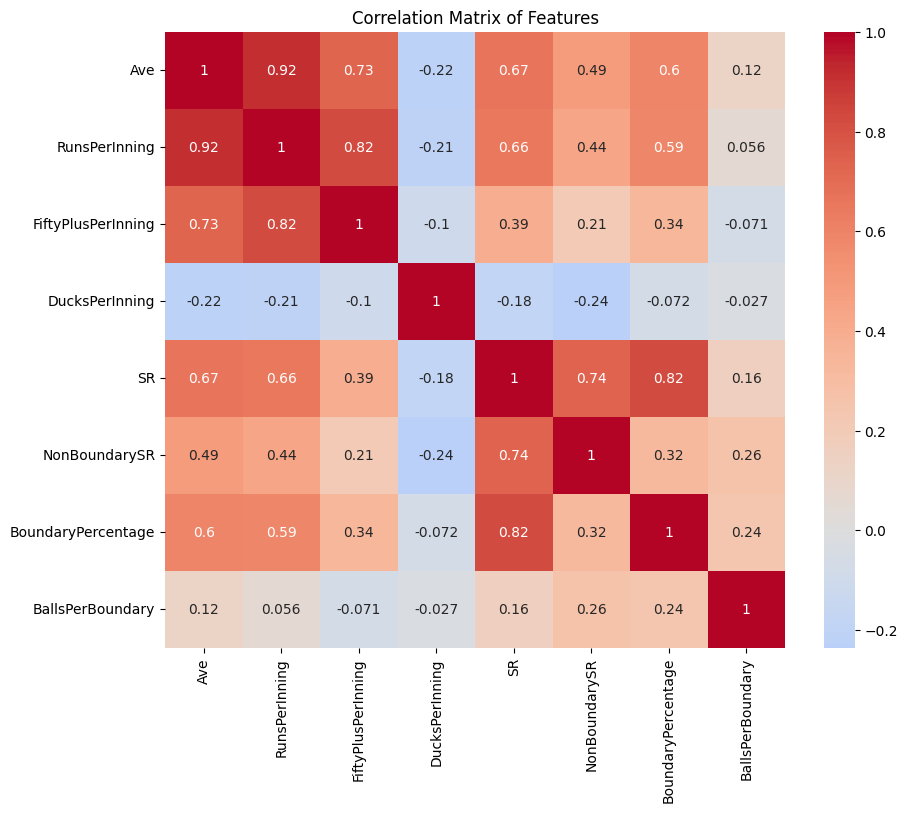


All Seasons Ratings:
              Player  Consistency      Form  Overall_Rating
344   Vivrant Sharma     0.738889  0.795733        0.755942
252       MN van Wyk     0.433262  0.652680        0.499087
104        DP Conway     0.448831  0.611243        0.497554
91   B Sai Sudharsan     0.407031  0.594242        0.463194
10          KL Rahul     0.408741  0.574771        0.458550
..               ...          ...       ...             ...
674          K Yadav     0.000000  0.000000        0.000000
673     TP Sudhindra     0.000000  0.000000        0.000000
672           KR Sen     0.000000  0.000000        0.000000
671   R Sanjay Yadav     0.000000  0.000000        0.000000
734         MP Yadav     0.000000  0.000000        0.000000

[735 rows x 4 columns]


In [5]:
try:
    print("\nProcessing All Seasons Dataset:")
    all_seasons_df = process_batting_data('/Users/dog/Documents/CricketSquadSelection/all seasons/batsamset_ipl.xlsx')
    all_seasons_analysis = analyze_and_visualize(all_seasons_df)
    all_seasons_ratings = calculate_ratings(all_seasons_analysis, all_seasons_df)
    print("\nAll Seasons Ratings:")
    print(all_seasons_ratings)
except Exception as e:
    print(f"Error processing all seasons data: {str(e)}")

/var/folders/mk/9dydvdvn7ldgkc8zfmkv95fh0000gn/T/ipykernel_9391/912519130.py:25: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[col] = df[col].replace('-', 0).astype(float)



Processing Last Season Dataset:
Original columns: ['Player', 'Mat', 'Inns', 'NO', 'Runs', 'HS', 'Ave', 'BF', 'SR', "100's", "50's", 0, '4s', '6s']


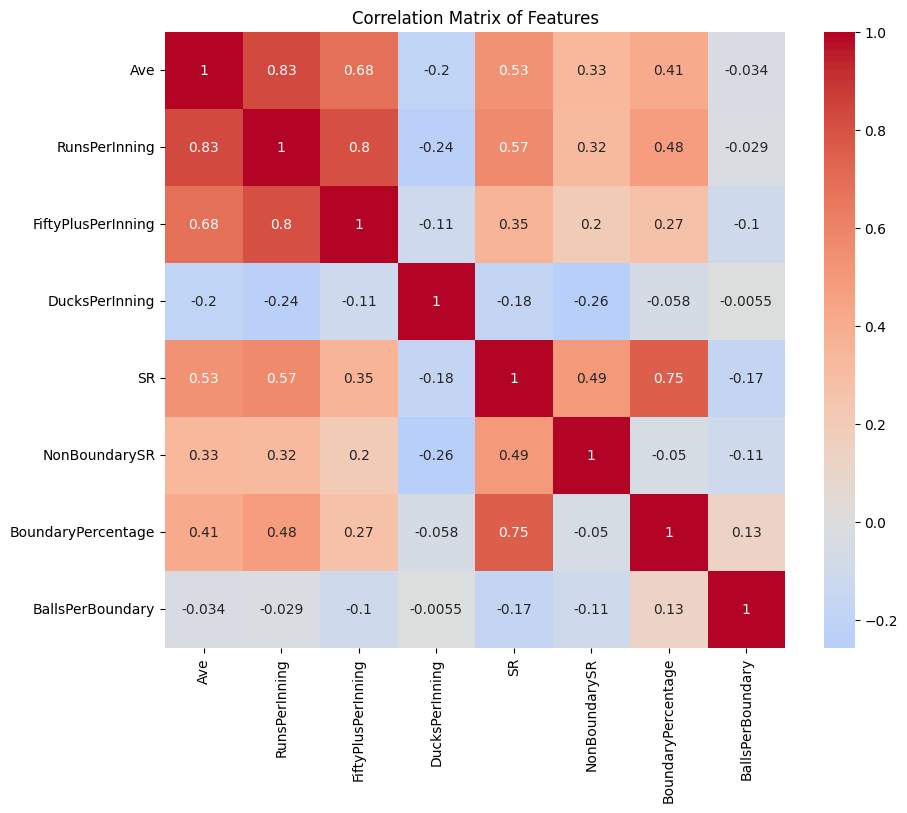


Last Season Ratings:
             Player  Consistency      Form  Overall_Rating
367    Yuvraj Singh     0.603125  0.784200        0.657447
217  K Rohit Rayudu     0.609376  0.720419        0.642689
228         CS Jani     0.508126  0.793642        0.593781
218        HM Patel     0.506555  0.701941        0.565171
147        UD Yadav     0.495846  0.690842        0.554345
..              ...          ...       ...             ...
446      VVK Ranjan     0.013016  0.025070        0.016632
450     Vikas Kumar     0.000000  0.000000        0.000000
447      Avesh Khan     0.000000  0.000000        0.000000
449       MM Sharma     0.000000  0.000000        0.000000
448       SK Prasad     0.000000  0.000000        0.000000

[541 rows x 4 columns]


In [6]:
try:
    print("\nProcessing Last Season Dataset:")
    last_season_df = process_batting_data('/Users/dog/Documents/CricketSquadSelection/lastseason/Lastseasonbatsman_smat.xlsx')
    last_season_analysis = analyze_and_visualize(last_season_df)
    last_season_ratings = calculate_ratings(last_season_analysis, last_season_df)
    print("\nLast Season Ratings:")
    print(last_season_ratings)
except Exception as e:
    print(f"Error processing last season data: {str(e)}")

In [8]:
import os

def save_processed_data(ratings_df, analysis_df, original_df, season_type):
    # Create new directory if it doesn't exist
    output_dir = '/Users/dog/Documents/CricketSquadSelection/processed_data'
    os.makedirs(output_dir, exist_ok=True)
    
    # Generate filenames with timestamp to avoid overwriting
    timestamp = pd.Timestamp.now().strftime('%Y%m%d_%H%M%S')
    
    # Save ratings
    ratings_filename = f'{season_type}_ratings_.xlsx'
    ratings_path = os.path.join(output_dir, ratings_filename)
    ratings_df.to_excel(ratings_path, index=False)
    print(f"Ratings saved to: {ratings_path}")
    
    # Save analysis data
    analysis_filename = f'{season_type}_analysis_.xlsx'
    analysis_path = os.path.join(output_dir, analysis_filename)
    analysis_df.to_excel(analysis_path, index=False)
    print(f"Analysis data saved to: {analysis_path}")
    
    # Save full processed data
    processed_filename = f'{season_type}_full_processed_.xlsx'
    processed_path = os.path.join(output_dir, processed_filename)
    original_df.to_excel(processed_path, index=False)
    print(f"Full processed data saved to: {processed_path}")

# Save All Seasons data
try:
    save_processed_data(
        all_seasons_ratings,
        all_seasons_analysis,
        all_seasons_df,
        'all_seasons'
    )
except Exception as e:
    print(f"Error saving all seasons data: {str(e)}")

# Save Last Season data
try:
    save_processed_data(
        last_season_ratings,
        last_season_analysis,
        last_season_df,
        'last_season'
    )
except Exception as e:
    print(f"Error saving last season data: {str(e)}")

Ratings saved to: /Users/dog/Documents/CricketSquadSelection/processed_data/all_seasons_ratings_.xlsx
Analysis data saved to: /Users/dog/Documents/CricketSquadSelection/processed_data/all_seasons_analysis_.xlsx
Full processed data saved to: /Users/dog/Documents/CricketSquadSelection/processed_data/all_seasons_full_processed_.xlsx
Ratings saved to: /Users/dog/Documents/CricketSquadSelection/processed_data/last_season_ratings_.xlsx
Analysis data saved to: /Users/dog/Documents/CricketSquadSelection/processed_data/last_season_analysis_.xlsx
Full processed data saved to: /Users/dog/Documents/CricketSquadSelection/processed_data/last_season_full_processed_.xlsx
